In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Train: 45000
Val: 5000
Test: 10000


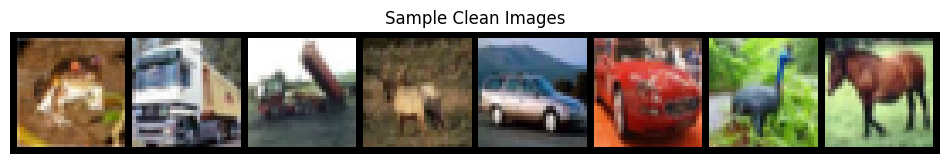

In [2]:
# -----------------------------
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_full = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# Normalize to [0,1] already done by ToTensor

n_total = len(train_full)
n_val = int(n_total * VAL_RATIO)
n_train = n_total - n_val

train_set, val_set = random_split(train_full, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_set))
print("Val:", len(val_set))
print("Test:", len(test_set))

# -----------------------------
# Dataset Visualization
# -----------------------------

def show_samples(dataset, n=8):
    imgs = [dataset[i][0] for i in range(n)]
    grid = torchvision.utils.make_grid(imgs, nrow=n)
    plt.figure(figsize=(12,3))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title("Sample Clean Images")
    plt.show()

show_samples(train_full)

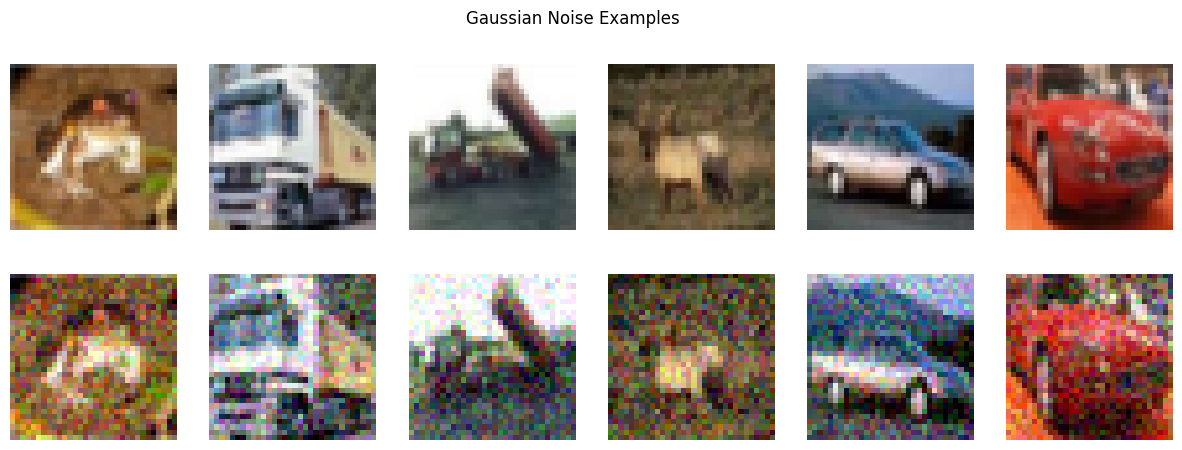

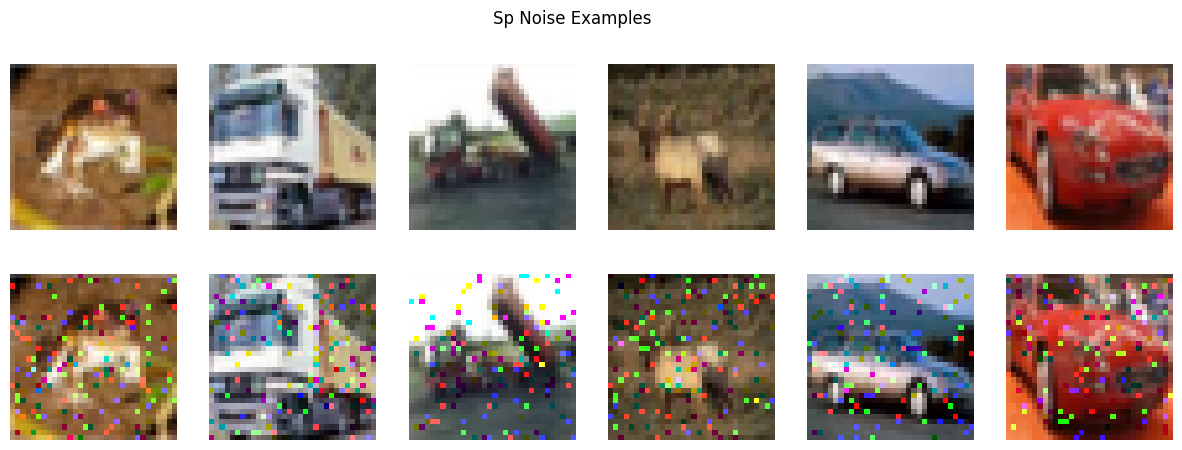

In [3]:
# -----------------------------
# 2. Noise Injection
# -----------------------------

def add_gaussian_noise(x, mean=0.0, std=0.1):
    noise = torch.randn_like(x) * std + mean
    noisy = x + noise
    return torch.clamp(noisy, 0., 1.)


def add_salt_pepper_noise(x, prob=0.05):
    noisy = x.clone()
    rand = torch.rand_like(noisy)
    noisy[rand < prob/2] = 0
    noisy[rand > 1 - prob/2] = 1
    return noisy


# Visualize Noise

def show_noise_examples(dataset, noise_type="gaussian"):
    imgs = [dataset[i][0] for i in range(6)]

    if noise_type == "gaussian":
        noisy = [add_gaussian_noise(i) for i in imgs]
    else:
        noisy = [add_salt_pepper_noise(i) for i in imgs]

    fig, ax = plt.subplots(2,6, figsize=(15,5))

    for i in range(6):
        ax[0,i].imshow(imgs[i].permute(1,2,0))
        ax[1,i].imshow(noisy[i].permute(1,2,0))
        ax[0,i].axis("off")
        ax[1,i].axis("off")

    ax[0,0].set_ylabel("Clean")
    ax[1,0].set_ylabel("Noisy")
    plt.suptitle(f"{noise_type.title()} Noise Examples")
    plt.show()

show_noise_examples(train_full, "gaussian")
show_noise_examples(train_full, "sp")


In [4]:
# -----------------------------
# 3. Model Architecture
# -----------------------------

class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*4*4, latent_dim)
        )

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,3,3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder_fc(z)
        x = x.view(-1,256,4,4)
        x = self.decoder(x)
        return x


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = DenoisingAutoencoder(latent_dim=256)
print(model)
print("Trainable Parameters:", count_params(model))

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=256, bias=True)
  )
  (decoder_fc): Linear(in_features=256, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)
Trainable Parameters: 2842883


Epoch 1/10 | Train: 0.0201 | Val: 0.0111
Epoch 2/10 | Train: 0.0093 | Val: 0.0077
Epoch 3/10 | Train: 0.0069 | Val: 0.0072
Epoch 4/10 | Train: 0.0060 | Val: 0.0056
Epoch 5/10 | Train: 0.0053 | Val: 0.0051
Epoch 6/10 | Train: 0.0048 | Val: 0.0047
Epoch 7/10 | Train: 0.0045 | Val: 0.0043
Epoch 8/10 | Train: 0.0042 | Val: 0.0041
Epoch 9/10 | Train: 0.0040 | Val: 0.0040
Epoch 10/10 | Train: 0.0039 | Val: 0.0039


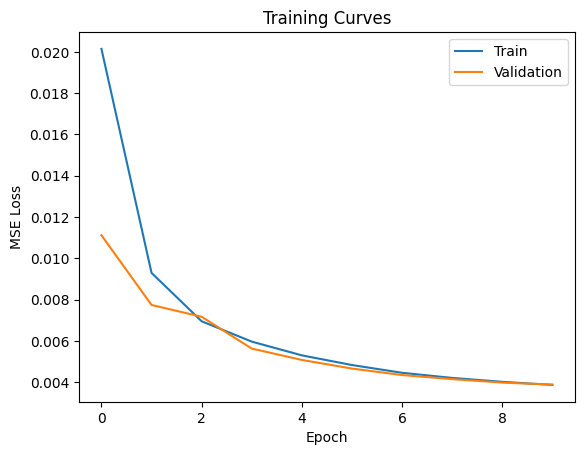

In [5]:
# -----------------------------
# 4. Training Setup
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
NOISE_STD = 0.1

train_losses = []
val_losses = []


def train_model(model, noise="gaussian"):

    for epoch in range(EPOCHS):

        model.train()
        running_loss = 0

        for imgs,_ in train_loader:
            imgs = imgs.to(device)

            if noise == "gaussian":
                noisy = add_gaussian_noise(imgs, std=NOISE_STD)
            else:
                noisy = add_salt_pepper_noise(imgs)

            noisy = noisy.to(device)

            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for imgs,_ in val_loader:
                imgs = imgs.to(device)

                if noise == "gaussian":
                    noisy = add_gaussian_noise(imgs, std=NOISE_STD)
                else:
                    noisy = add_salt_pepper_noise(imgs)

                noisy = noisy.to(device)
                outputs = model(noisy)
                loss = criterion(outputs, imgs)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")


train_model(model, noise="gaussian")

# -----------------------------
# Training Curves
# -----------------------------

plt.plot(train_losses,label="Train")
plt.plot(val_losses,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Curves")
plt.show()

Average MSE: 0.0038611053
Average PSNR: 24.579024888664414
Average SSIM: 0.8273456


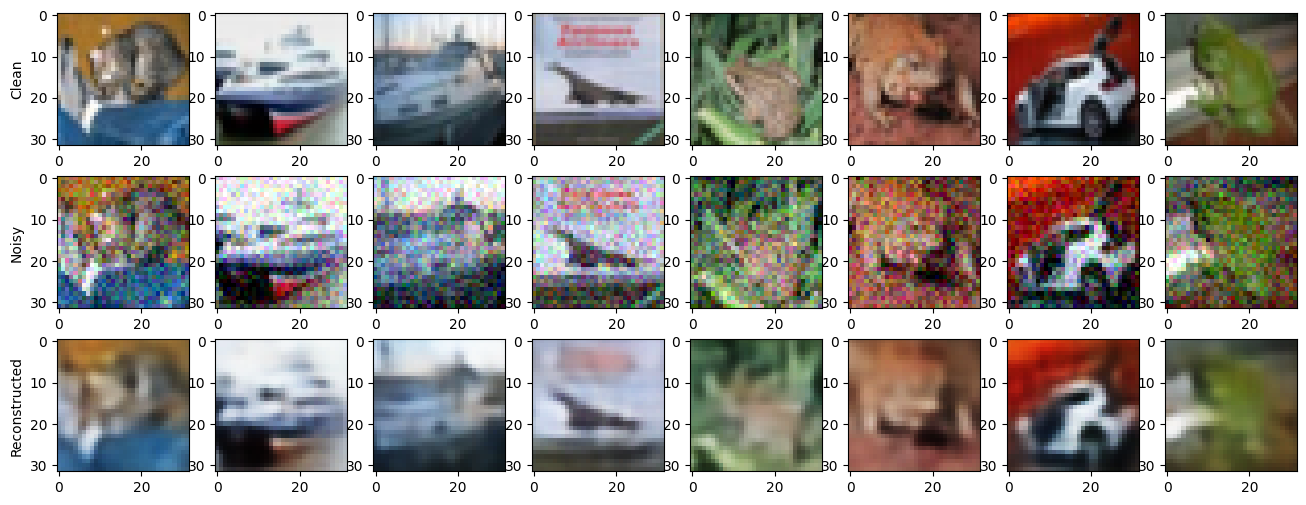

In [11]:
# -----------------------------
# 5. Evaluation
# -----------------------------

model.eval()

mse_list = []
psnr_list = []
ssim_list = []

with torch.no_grad():
    for imgs,_ in test_loader:

        imgs = imgs.to(device)
        noisy = add_gaussian_noise(imgs, std=NOISE_STD).to(device)

        outputs = model(noisy)

        imgs_np = imgs.cpu().numpy()
        out_np = outputs.detach().cpu().numpy()

        for i in range(imgs_np.shape[0]):
            mse = np.mean((imgs_np[i]-out_np[i])**2)
            mse_list.append(mse)

            p = psnr(imgs_np[i], out_np[i], data_range=1)
            s = ssim(imgs_np[i].transpose(1,2,0),
                     out_np[i].transpose(1,2,0),
                     channel_axis=2,
                     data_range=1)

            psnr_list.append(p)
            ssim_list.append(s)

print("Average MSE:", np.mean(mse_list))
print("Average PSNR:", np.mean(psnr_list))
print("Average SSIM:", np.mean(ssim_list))

# -----------------------------
# Visualization Results
# -----------------------------

def show_reconstructions():

    imgs,_ = next(iter(test_loader))
    imgs = imgs[:8].to(device)

    noisy = add_gaussian_noise(imgs, std=NOISE_STD)
    outputs = model(noisy)

    imgs = imgs.cpu()
    noisy = noisy.cpu()
    outputs = outputs.detach().cpu()

    fig, ax = plt.subplots(3,8, figsize=(16,6))

    for i in range(8):
        ax[0,i].imshow(imgs[i].permute(1,2,0))
        ax[1,i].imshow(noisy[i].permute(1,2,0))
        ax[2,i].imshow(outputs[i].permute(1,2,0))

        ax[0,i].axis("off")
        ax[1,i].axis("off")
        ax[2,i].axis("off")

    ax[0,0].set_ylabel("Clean")
    ax[1,0].set_ylabel("Noisy")
    ax[2,0].set_ylabel("Reconstructed")

    plt.show()

show_reconstructions()

Epoch 1/10 | Train: 0.0201 | Val: 0.0120
Epoch 2/10 | Train: 0.0103 | Val: 0.0093
Epoch 3/10 | Train: 0.0087 | Val: 0.0083
Epoch 4/10 | Train: 0.0081 | Val: 0.0081
Epoch 5/10 | Train: 0.0079 | Val: 0.0080
Epoch 6/10 | Train: 0.0078 | Val: 0.0079
Epoch 7/10 | Train: 0.0077 | Val: 0.0078
Epoch 8/10 | Train: 0.0077 | Val: 0.0079
Epoch 9/10 | Train: 0.0076 | Val: 0.0078
Epoch 10/10 | Train: 0.0076 | Val: 0.0077
Epoch 1/10 | Train: 0.0226 | Val: 0.0122
Epoch 2/10 | Train: 0.0106 | Val: 0.0095
Epoch 3/10 | Train: 0.0088 | Val: 0.0085
Epoch 4/10 | Train: 0.0083 | Val: 0.0083
Epoch 5/10 | Train: 0.0081 | Val: 0.0082
Epoch 6/10 | Train: 0.0080 | Val: 0.0080
Epoch 7/10 | Train: 0.0079 | Val: 0.0082
Epoch 8/10 | Train: 0.0079 | Val: 0.0080
Epoch 9/10 | Train: 0.0078 | Val: 0.0079
Epoch 10/10 | Train: 0.0078 | Val: 0.0080
Epoch 1/10 | Train: 0.0222 | Val: 0.0126
Epoch 2/10 | Train: 0.0111 | Val: 0.0102
Epoch 3/10 | Train: 0.0096 | Val: 0.0093
Epoch 4/10 | Train: 0.0089 | Val: 0.0089
Epoch 5/10 | T

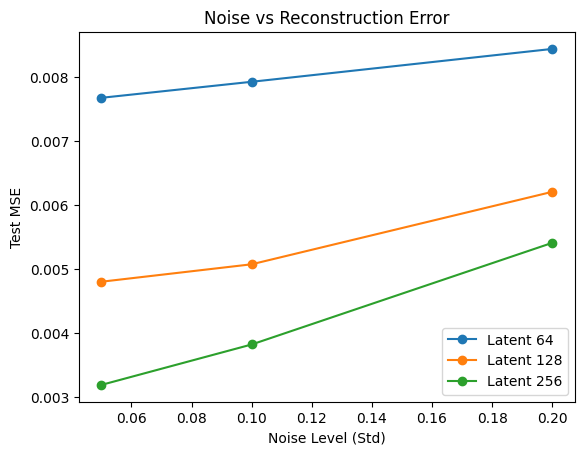

'\nOBSERVATIONS:\n1. Higher noise increases reconstruction error.\n2. Larger latent size improves performance.\n3. Small bottleneck causes over-compression.\n4. Model handles Gaussian noise better than salt-pepper.\n\nLIMITATIONS:\n- Blurry reconstructions\n- Limited depth\n- No perceptual loss\n\nIMPROVEMENTS:\n- Deeper CNN\n- Skip connections (U-Net)\n- Perceptual loss\n- Data augmentation\n'

In [12]:
# -----------------------------
# 6. Experimental Study
# -----------------------------

latent_sizes = [64,128,256]
noise_levels = [0.05,0.1,0.2]

results = []

for ld in latent_sizes:
    for ns in noise_levels:

        model = DenoisingAutoencoder(latent_dim=ld).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        NOISE_STD = ns
        train_losses.clear()
        val_losses.clear()

        train_model(model, noise="gaussian")

        model.eval()
        mse_vals = []

        with torch.no_grad():
            for imgs,_ in test_loader:
                imgs = imgs.to(device)
                noisy = add_gaussian_noise(imgs,std=ns)
                out = model(noisy)
                mse = torch.mean((imgs-out)**2).item()
                mse_vals.append(mse)

        results.append([
            ld, ns, np.mean(mse_vals)
        ])


# -----------------------------
# Results Table
# -----------------------------

results_df = pd.DataFrame(
    results,
    columns=["Latent Dim","Noise Std","Test MSE"]
)

print("\nExperimental Results")
print(results_df)

# Plot Comparison

for ld in latent_sizes:
    sub = results_df[results_df["Latent Dim"]==ld]
    plt.plot(sub["Noise Std"], sub["Test MSE"], marker='o', label=f"Latent {ld}")

plt.xlabel("Noise Level (Std)")
plt.ylabel("Test MSE")
plt.title("Noise vs Reconstruction Error")
plt.legend()
plt.show()

# -----------------------------
# Discussion (Write in Report)
# -----------------------------

"""
OBSERVATIONS:
1. Higher noise increases reconstruction error.
2. Larger latent size improves performance.
3. Small bottleneck causes over-compression.
4. Model handles Gaussian noise better than salt-pepper.

LIMITATIONS:
- Blurry reconstructions
- Limited depth
- No perceptual loss

IMPROVEMENTS:
- Deeper CNN
- Skip connections (U-Net)
- Perceptual loss
- Data augmentation
"""
